# Analysis of Z3 (master, commit: da0e140) on HWMCC20 Rules

- Start: Thursday, October 30, 2020 at 01:27:09
- End: Thursday, October 30, 2020 at 21:20:47
- Timeout: 900 seconds
- Branch: `z3m-da0e140`
- Arguments: `-st -v:1 -T:900 fp.xform.slice=true fp.xform.inline_linear=true fp.xform.inline_eager=true fp.xform.tail_simplifier_pve=true fp.engine=spacer fp.print_statistics=true fp.spacer.elim_aux=true fp.spacer.reach_dnf=true fp.spacer.iuc=1 fp.spacer.iuc.arith=1 fp.validate=true fp.spacer.ground_pobs=true fp.spacer.mbqi=false fp.spacer.iuc.print_farkas_stats=false fp.spacer.iuc.old_hyp_reducer=false fp.spacer.ctp=true fp.spacer.weak_abs=true fp.spacer.native_mbp=true`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List


# noinspection PyUnresolvedReferences
pd.set_option('display.max_rows', None)
# noinspection PyUnresolvedReferences
pd.set_option('display.max_colwidth', None)

sns.set(style='ticks', palette='Set2')
# noinspection PyUnresolvedReferences
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
out_dir: str = '../../out/z3m.hwmcc20-rules.lilla-my.30_10_2020-t01-27-09'

filename: str = 'z3m.hwmcc20-rules.lilla-my.30_10_2020-t01-27-09.csv'
df: pd.DataFrame = pd.read_csv(filename)

df['status'].fillna(value='(no status)', inplace=True)

timeout = 900
df['time'].fillna(value=timeout, inplace=True)
df.loc[df['status'] == 'unknown', 'time'] = timeout

# show a snapshot of data for visual validation
df.head()

,index,SPACER_cex_depth,SPACER_expand_pob_undef,SPACER_inductive_level,SPACER_max_depth,SPACER_max_query_lvl,SPACER_num_active_lemmas,SPACER_num_ctp_blocked,SPACER_num_invariants,SPACER_num_is_invariant,...,time_spacer_ctp,time_spacer_init_rules,time_spacer_init_rules_pt_init,time_spacer_mbp,time_spacer_solve,time_spacer_solve_propagate,time_spacer_solve_reach,time_spacer_solve_reach_children,time_spacer_solve_reach_gen_bool_ind,time_spacer_solve_reach_is_reach
0,array-VexRiscv-regch0-15-p0.smt2,NaN,NaN,NaN,15.0,14.0,464.0,96.0,325.0,1216.0,...,0.28,0.06,0.06,7.57,845.13,81.14,763.95,10.39,635.11,NaN
1,array-VexRiscv-regch0-15-p1.smt2,NaN,NaN,NaN,10.0,10.0,126.0,13.0,79.0,196.0,...,0.01,0.06,0.06,1.60,76.51,3.72,72.75,2.41,56.13,NaN
2,array-VexRiscv-regch0-20-p0.smt2,NaN,NaN,NaN,15.0,14.0,561.0,73.0,384.0,1406.0,...,0.72,0.05,0.05,8.09,687.36,70.12,617.19,11.49,498.30,NaN
3,array-arbitrated_fifos_n2d8w8.smt2,NaN,NaN,NaN,23.0,22.0,1085.0,21.0,47.0,9416.0,...,0.00,0.01,0.00,5.94,799.88,286.36,513.44,8.59,389.77,NaN
4,array-array_swap.smt2,NaN,NaN,NaN,71.0,70.0,274.0,69.0,NaN,13215.0,...,0.00,0.00,NaN,1.16,867.89,526.85,340.80,4.45,23.21,NaN


In [3]:
# quick overview of solved/unsolved instances
df[['status', 'index']].groupby('status').count()

,index
status,
(no status),7
timeout,632


In [4]:
df.query('status == "(no status)"')[['index', 'status']]

,index,status
134,array-easy_zero_array.smt2,(no status)
135,array-marlann_compute_fail1-p0.smt2,(no status)
138,array-marlann_compute_fail2-p1.smt2,(no status)
139,array-marlann_compute_fail2-p2.smt2,(no status)
158,array-picorv32_mutBY_mem-p8.smt2,(no status)
425,bv-frogs.5.prop1-func-interl.smt2,(no status)
619,bv-zipcpu-pfcache-p24.smt2,(no status)


In [5]:
# Find unknown results. Usually means that something went wrong, not just timeout.
unknown_df: pd.DataFrame = df.query('status == "unknown"')[['index', 'status']]

def get_error(index: str) -> str:
    with open(os.path.join(out_dir, index)) as f:
        return f.readline().strip()

unknown_df['error'] = unknown_df['index'].apply(get_error)
unknown_df.sort_values('error').head()

,index,status,error


In [6]:
unknown_df.groupby('error')[['index']].agg(['first', 'count'])

Empty DataFrame
Columns: [(index, first), (index, count)]
Index: []

## HWMCC20 modelcheckers

In [7]:
pd.read_csv('http://fmv.jku.at/hwmcc20/hwmcc20-combined-all.txt', delim_whitespace=True)

,cnt,ok,sat,uns,dis,fld,to,mo,unk,real,time,space,max,best,uniq
avr,639,547,66,481,0,92,0,0,92,71456,1049649,2282407,49141,100,23
nuxmv,639,500,50,450,0,139,139,0,0,99664,339693,505974,6898,12,2
pono,639,386,58,328,0,253,219,22,12,63789,288937,596666,77761,38,1
cosa2,639,373,58,315,0,266,252,1,13,136153,537672,585138,14623,17,0
btormc,639,333,59,274,0,306,305,0,1,53822,53797,47550,2565,208,2
abc,324,262,56,206,0,62,62,0,0,36505,429078,344728,31293,29,1
abc17,324,262,55,207,0,62,62,0,0,39465,470045,352773,31820,10,1
pdtrav,324,245,45,200,0,79,76,0,3,74891,429930,713508,30090,8,2
avy,324,236,40,196,0,88,88,0,0,44055,437528,426064,14949,25,0
nmtip,324,210,17,193,26,88,88,0,0,24949,24933,17119,3117,142,13


In [8]:
# The values of the result column are unknown if all model checkers
# gives unknown, or if the number of model checkers that says sat
# and the number of those that say unsat tie. Otherwise, the values
# are sat or unsat based on the majority of the model checkers.
hwmcc20_results: pd.DataFrame = pd.read_csv('../hwmcc20-results.csv')
hwmcc20_results['index'] = hwmcc20_results['index'].apply(lambda idx: idx + '.smt2')
hwmcc20_results.head()

,index,result,sat_count,uns_count,unk_count,low_bound,high_bound,avg_bound,low_real,high_real,avg_real,low_time,high_timeavg_time,low_mem,high_mem,avg_mem,avg_time,high_time
0,array-VexRiscv-regch0-15-p0.smt2,unsat,0,5,0,-1,-1,-1.0,9.40,2857.39,586.858,9.30,NaN,82.0,2633.0,1112.0,1779.746,8570.64
1,array-VexRiscv-regch0-15-p1.smt2,unsat,0,5,0,-1,-1,-1.0,9.59,3105.02,641.160,9.46,NaN,79.0,4350.0,1388.4,1355.362,6296.49
2,array-VexRiscv-regch0-20-p0.smt2,unsat,0,4,0,-1,-1,-1.0,228.44,3600.10,1017.224,228.36,NaN,209.0,10376.0,3061.4,3822.140,8203.90
3,array-arbitrated_fifos_n2d8w8.smt2,unknown,0,0,2,-1,-1,-1.0,0.74,3600.10,2874.864,1.46,NaN,82.0,4803.0,1544.2,10024.040,28426.36
4,array-array_swap.smt2,unknown,0,0,2,-1,-1,-1.0,0.42,3600.10,2875.386,0.09,NaN,31.0,24699.0,9013.2,13639.468,46507.75


In [9]:
hwmcc20_results[['result', 'index']].groupby(['result']).count()

,index
result,
sat,84
unknown,43
unsat,512


## Compare Z3m and HWMCC20 modelcheckers

In [10]:
m: pd.DataFrame = pd.merge(df, hwmcc20_results, on='index')
m.head()

,index,SPACER_cex_depth,SPACER_expand_pob_undef,SPACER_inductive_level,SPACER_max_depth,SPACER_max_query_lvl,SPACER_num_active_lemmas,SPACER_num_ctp_blocked,SPACER_num_invariants,SPACER_num_is_invariant,...,low_real,high_real,avg_real,low_time,high_timeavg_time,low_mem,high_mem,avg_mem,avg_time,high_time
0,array-VexRiscv-regch0-15-p0.smt2,NaN,NaN,NaN,15.0,14.0,464.0,96.0,325.0,1216.0,...,9.40,2857.39,586.858,9.30,NaN,82.0,2633.0,1112.0,1779.746,8570.64
1,array-VexRiscv-regch0-15-p1.smt2,NaN,NaN,NaN,10.0,10.0,126.0,13.0,79.0,196.0,...,9.59,3105.02,641.160,9.46,NaN,79.0,4350.0,1388.4,1355.362,6296.49
2,array-VexRiscv-regch0-20-p0.smt2,NaN,NaN,NaN,15.0,14.0,561.0,73.0,384.0,1406.0,...,228.44,3600.10,1017.224,228.36,NaN,209.0,10376.0,3061.4,3822.140,8203.90
3,array-arbitrated_fifos_n2d8w8.smt2,NaN,NaN,NaN,23.0,22.0,1085.0,21.0,47.0,9416.0,...,0.74,3600.10,2874.864,1.46,NaN,82.0,4803.0,1544.2,10024.040,28426.36
4,array-array_swap.smt2,NaN,NaN,NaN,71.0,70.0,274.0,69.0,NaN,13215.0,...,0.42,3600.10,2875.386,0.09,NaN,31.0,24699.0,9013.2,13639.468,46507.75


In [11]:
m[['status', 'index', 'result']].groupby(['status', 'result']).count()

index
status      result        
(no status) sat          3
            unknown      1
            unsat        3
timeout     sat         81
            unknown     42
            unsat      509

In [12]:
# {sat|uns|unk}_count: The number of model checkers
#                      that gives {sat|unsat|unknown}
query_columns: List[str] = ['index', 'status', 'result', 'time', 'memory',
                            'sat_count', 'uns_count', 'unk_count']
m.query('status == "sat" & result == "unsat"')[query_columns].sort_values('time')

,index,status,result,time,memory,sat_count,uns_count,unk_count


For `bv-vcegar_arrays_itc99_b12_p2.smt2` and `bv-rast-p17.smt2`, only nmtip says unsat.

In [13]:
m.query('status == "unsat" & result == "sat"')[query_columns].sort_values('time')

,index,status,result,time,memory,sat_count,uns_count,unk_count


In [14]:
m.query('status == "sat" & result == "unknown"')[query_columns].sort_values('time')

,index,status,result,time,memory,sat_count,uns_count,unk_count


In [15]:
m.query('status == "unsat" & result == "unknown"')[query_columns].sort_values('time')

,index,status,result,time,memory,sat_count,uns_count,unk_count


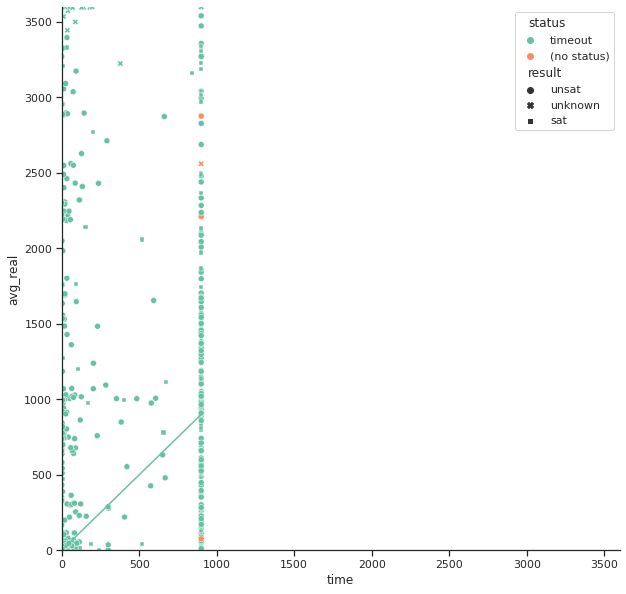

In [16]:
plt.xlim(0, 3600)
plt.ylim(0, 3600)
g = sns.scatterplot(x='time', y='avg_real', hue='status', style='result', data=m)
sns.despine()
x = np.linspace(0, 900, 2)
g.plot(x, x)

## BV

In [17]:
df['index'].str.startswith('bv')
df_bv: pd.DataFrame = df[df['index'].str.startswith('bv-')]
df_bv.head()

,index,SPACER_cex_depth,SPACER_expand_pob_undef,SPACER_inductive_level,SPACER_max_depth,SPACER_max_query_lvl,SPACER_num_active_lemmas,SPACER_num_ctp_blocked,SPACER_num_invariants,SPACER_num_is_invariant,...,time_spacer_ctp,time_spacer_init_rules,time_spacer_init_rules_pt_init,time_spacer_mbp,time_spacer_solve,time_spacer_solve_propagate,time_spacer_solve_reach,time_spacer_solve_reach_children,time_spacer_solve_reach_gen_bool_ind,time_spacer_solve_reach_is_reach
315,bv-VexRiscv-regch0-15-p0.smt2,NaN,NaN,NaN,16.0,15.0,402.0,191.0,273.0,1389.0,...,1.52,0.08,0.08,6.38,594.34,87.19,507.10,9.39,403.53,NaN
316,bv-VexRiscv-regch0-20-p0.smt2,NaN,NaN,NaN,13.0,12.0,423.0,82.0,240.0,1149.0,...,1.30,0.08,0.07,7.37,728.07,89.70,638.34,10.57,531.85,NaN
317,bv-VexRiscv-regch0-30-p1.smt2,NaN,NaN,NaN,15.0,14.0,368.0,129.0,262.0,1129.0,...,1.35,0.08,0.08,5.96,489.60,60.04,429.52,9.15,335.05,NaN
318,bv-anderson.3.prop1-back-serstep.smt2,4.0,NaN,NaN,4.0,4.0,8.0,2.0,NaN,9.0,...,NaN,0.01,0.00,0.01,6.55,0.35,6.20,0.01,3.68,1.03
319,bv-arbitrated_top_n2_w128_d32_e0.smt2,NaN,NaN,NaN,13.0,12.0,921.0,1088.0,1.0,3943.0,...,1.67,0.09,0.09,2.30,732.49,118.31,614.15,4.51,529.74,NaN


In [18]:
# quick overview of solved/unsolved instances
df_bv[['status', 'index']].groupby(['status']).count()

,index
status,
(no status),2
timeout,322


In [19]:
df_bv.query('status == "(no status)"')[['index', 'status']]

,index,status
425,bv-frogs.5.prop1-func-interl.smt2,(no status)
619,bv-zipcpu-pfcache-p24.smt2,(no status)


In [20]:
unknown_df_bv: pd.DataFrame = unknown_df[unknown_df['index'].str.startswith('bv-')]
unknown_df_bv.head()

,index,status,error


In [21]:
unknown_df_bv.groupby('error')[['index']].agg(['first', 'count'])

Empty DataFrame
Columns: [(index, first), (index, count)]
Index: []

In [22]:
hwmcc20_results_bv: pd.DataFrame = hwmcc20_results[hwmcc20_results['index'].str.startswith('bv-')]
hwmcc20_results_bv.head()

,index,result,sat_count,uns_count,unk_count,low_bound,high_bound,avg_bound,low_real,high_real,avg_real,low_time,high_timeavg_time,low_mem,high_mem,avg_mem,avg_time,high_time
315,bv-VexRiscv-regch0-15-p0.smt2,unsat,0,8,1,-1,-1,-1.000000,6.28,3600.11,680.350909,6.19,NaN,91.0,16828.0,4166.545455,4722.890000,35991.59
316,bv-VexRiscv-regch0-20-p0.smt2,unsat,0,8,1,-1,-1,-1.000000,52.68,3600.10,891.460909,52.59,NaN,161.0,31820.0,10455.272727,6538.323636,35992.53
317,bv-VexRiscv-regch0-30-p1.smt2,unsat,0,6,1,-1,-1,-1.000000,254.53,3600.11,2101.825455,254.49,NaN,722.0,110681.0,28088.818182,14905.270909,35903.45
318,bv-anderson.3.prop1-back-serstep.smt2,sat,11,0,0,-1,4,1.272727,0.03,3.13,0.594545,0.00,NaN,0.0,1753.0,309.363636,0.810909,4.54
319,bv-arbitrated_top_n2_w128_d32_e0.smt2,sat,5,0,0,-1,-1,-1.000000,591.76,3600.11,2364.781818,1647.68,NaN,225.0,14825.0,5186.272727,15454.903636,44492.40


In [23]:
m_bv: pd.DataFrame = pd.merge(df_bv, hwmcc20_results_bv, on='index')
m_bv.head()

,index,SPACER_cex_depth,SPACER_expand_pob_undef,SPACER_inductive_level,SPACER_max_depth,SPACER_max_query_lvl,SPACER_num_active_lemmas,SPACER_num_ctp_blocked,SPACER_num_invariants,SPACER_num_is_invariant,...,low_real,high_real,avg_real,low_time,high_timeavg_time,low_mem,high_mem,avg_mem,avg_time,high_time
0,bv-VexRiscv-regch0-15-p0.smt2,NaN,NaN,NaN,16.0,15.0,402.0,191.0,273.0,1389.0,...,6.28,3600.11,680.350909,6.19,NaN,91.0,16828.0,4166.545455,4722.890000,35991.59
1,bv-VexRiscv-regch0-20-p0.smt2,NaN,NaN,NaN,13.0,12.0,423.0,82.0,240.0,1149.0,...,52.68,3600.10,891.460909,52.59,NaN,161.0,31820.0,10455.272727,6538.323636,35992.53
2,bv-VexRiscv-regch0-30-p1.smt2,NaN,NaN,NaN,15.0,14.0,368.0,129.0,262.0,1129.0,...,254.53,3600.11,2101.825455,254.49,NaN,722.0,110681.0,28088.818182,14905.270909,35903.45
3,bv-anderson.3.prop1-back-serstep.smt2,4.0,NaN,NaN,4.0,4.0,8.0,2.0,NaN,9.0,...,0.03,3.13,0.594545,0.00,NaN,0.0,1753.0,309.363636,0.810909,4.54
4,bv-arbitrated_top_n2_w128_d32_e0.smt2,NaN,NaN,NaN,13.0,12.0,921.0,1088.0,1.0,3943.0,...,591.76,3600.11,2364.781818,1647.68,NaN,225.0,14825.0,5186.272727,15454.903636,44492.40


In [24]:
m_bv[['status', 'index', 'result']].groupby(['status', 'result']).count()

index
status      result        
(no status) unsat        2
timeout     sat         65
            unknown     21
            unsat      236

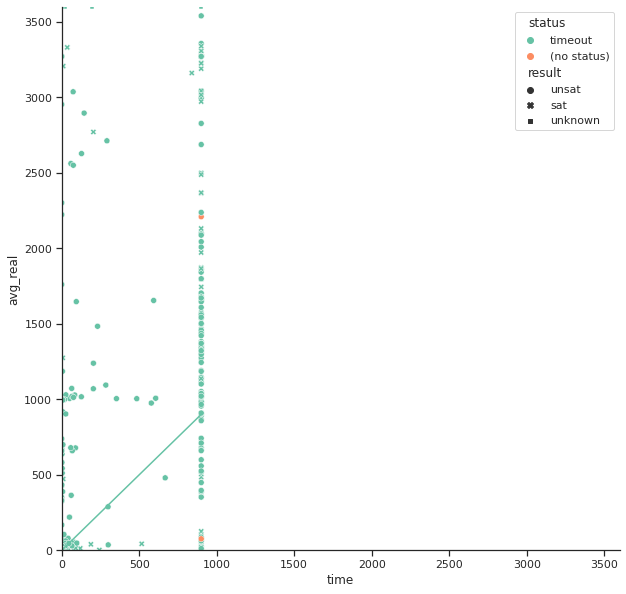

In [25]:
plt.xlim(0, 3600)
plt.ylim(0, 3600)
g = sns.scatterplot(x='time', y='avg_real', hue='status', style='result', data=m_bv)
sns.despine()
x = np.linspace(0, 900, 2)
g.plot(x, x)

## Array

In [26]:
df_array: pd.DataFrame = df[df['index'].str.startswith('array-')]
df_array.head()

,index,SPACER_cex_depth,SPACER_expand_pob_undef,SPACER_inductive_level,SPACER_max_depth,SPACER_max_query_lvl,SPACER_num_active_lemmas,SPACER_num_ctp_blocked,SPACER_num_invariants,SPACER_num_is_invariant,...,time_spacer_ctp,time_spacer_init_rules,time_spacer_init_rules_pt_init,time_spacer_mbp,time_spacer_solve,time_spacer_solve_propagate,time_spacer_solve_reach,time_spacer_solve_reach_children,time_spacer_solve_reach_gen_bool_ind,time_spacer_solve_reach_is_reach
0,array-VexRiscv-regch0-15-p0.smt2,NaN,NaN,NaN,15.0,14.0,464.0,96.0,325.0,1216.0,...,0.28,0.06,0.06,7.57,845.13,81.14,763.95,10.39,635.11,NaN
1,array-VexRiscv-regch0-15-p1.smt2,NaN,NaN,NaN,10.0,10.0,126.0,13.0,79.0,196.0,...,0.01,0.06,0.06,1.60,76.51,3.72,72.75,2.41,56.13,NaN
2,array-VexRiscv-regch0-20-p0.smt2,NaN,NaN,NaN,15.0,14.0,561.0,73.0,384.0,1406.0,...,0.72,0.05,0.05,8.09,687.36,70.12,617.19,11.49,498.30,NaN
3,array-arbitrated_fifos_n2d8w8.smt2,NaN,NaN,NaN,23.0,22.0,1085.0,21.0,47.0,9416.0,...,0.00,0.01,0.00,5.94,799.88,286.36,513.44,8.59,389.77,NaN
4,array-array_swap.smt2,NaN,NaN,NaN,71.0,70.0,274.0,69.0,NaN,13215.0,...,0.00,0.00,NaN,1.16,867.89,526.85,340.80,4.45,23.21,NaN


In [27]:
# quick overview of solved/unsolved instances
df_array[['status', 'index']].groupby('status').count()

,index
status,
(no status),5
timeout,310


In [28]:
df_array.query('status == "(no status)"')[['index', 'status']]

,index,status
134,array-easy_zero_array.smt2,(no status)
135,array-marlann_compute_fail1-p0.smt2,(no status)
138,array-marlann_compute_fail2-p1.smt2,(no status)
139,array-marlann_compute_fail2-p2.smt2,(no status)
158,array-picorv32_mutBY_mem-p8.smt2,(no status)


In [29]:
unknown_df_array: pd.DataFrame = unknown_df[unknown_df['index'].str.startswith('array-')]
unknown_df_array.head()

,index,status,error


In [30]:
unknown_df.groupby('error')[['index']].agg(['first', 'count'])

Empty DataFrame
Columns: [(index, first), (index, count)]
Index: []

In [31]:
hwmcc20_results_array: pd.DataFrame = hwmcc20_results[hwmcc20_results['index'].str.startswith('array-')]
hwmcc20_results_array.head()

,index,result,sat_count,uns_count,unk_count,low_bound,high_bound,avg_bound,low_real,high_real,avg_real,low_time,high_timeavg_time,low_mem,high_mem,avg_mem,avg_time,high_time
0,array-VexRiscv-regch0-15-p0.smt2,unsat,0,5,0,-1,-1,-1.0,9.40,2857.39,586.858,9.30,NaN,82.0,2633.0,1112.0,1779.746,8570.64
1,array-VexRiscv-regch0-15-p1.smt2,unsat,0,5,0,-1,-1,-1.0,9.59,3105.02,641.160,9.46,NaN,79.0,4350.0,1388.4,1355.362,6296.49
2,array-VexRiscv-regch0-20-p0.smt2,unsat,0,4,0,-1,-1,-1.0,228.44,3600.10,1017.224,228.36,NaN,209.0,10376.0,3061.4,3822.140,8203.90
3,array-arbitrated_fifos_n2d8w8.smt2,unknown,0,0,2,-1,-1,-1.0,0.74,3600.10,2874.864,1.46,NaN,82.0,4803.0,1544.2,10024.040,28426.36
4,array-array_swap.smt2,unknown,0,0,2,-1,-1,-1.0,0.42,3600.10,2875.386,0.09,NaN,31.0,24699.0,9013.2,13639.468,46507.75


In [32]:
m_array: pd.DataFrame = pd.merge(df_array, hwmcc20_results_array, on='index')
m_array.head()

,index,SPACER_cex_depth,SPACER_expand_pob_undef,SPACER_inductive_level,SPACER_max_depth,SPACER_max_query_lvl,SPACER_num_active_lemmas,SPACER_num_ctp_blocked,SPACER_num_invariants,SPACER_num_is_invariant,...,low_real,high_real,avg_real,low_time,high_timeavg_time,low_mem,high_mem,avg_mem,avg_time,high_time
0,array-VexRiscv-regch0-15-p0.smt2,NaN,NaN,NaN,15.0,14.0,464.0,96.0,325.0,1216.0,...,9.40,2857.39,586.858,9.30,NaN,82.0,2633.0,1112.0,1779.746,8570.64
1,array-VexRiscv-regch0-15-p1.smt2,NaN,NaN,NaN,10.0,10.0,126.0,13.0,79.0,196.0,...,9.59,3105.02,641.160,9.46,NaN,79.0,4350.0,1388.4,1355.362,6296.49
2,array-VexRiscv-regch0-20-p0.smt2,NaN,NaN,NaN,15.0,14.0,561.0,73.0,384.0,1406.0,...,228.44,3600.10,1017.224,228.36,NaN,209.0,10376.0,3061.4,3822.140,8203.90
3,array-arbitrated_fifos_n2d8w8.smt2,NaN,NaN,NaN,23.0,22.0,1085.0,21.0,47.0,9416.0,...,0.74,3600.10,2874.864,1.46,NaN,82.0,4803.0,1544.2,10024.040,28426.36
4,array-array_swap.smt2,NaN,NaN,NaN,71.0,70.0,274.0,69.0,NaN,13215.0,...,0.42,3600.10,2875.386,0.09,NaN,31.0,24699.0,9013.2,13639.468,46507.75


In [33]:
m_array[['status', 'index', 'result']].groupby(['status', 'result']).count()

index
status      result        
(no status) sat          3
            unknown      1
            unsat        1
timeout     sat         16
            unknown     21
            unsat      273

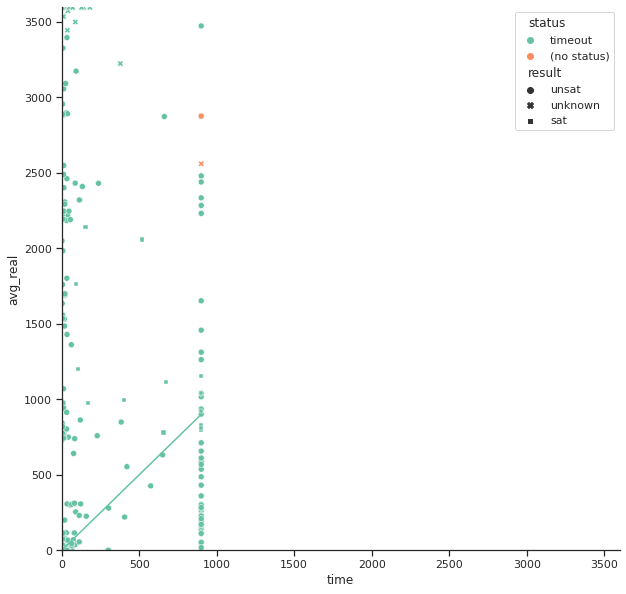

In [34]:
plt.xlim(0, 3600)
plt.ylim(0, 3600)
g = sns.scatterplot(x='time', y='avg_real', hue='status', style='result', data=m_array)
sns.despine()
x = np.linspace(0, 900, 2)
g.plot(x, x)